/var/folders/br/8_rtb5dd4ng41b3b4_j0zst80000gn/T/ipykernel_33545/3770093889.py:386: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_loc

Using device: cpu
Loaded 6587 images for test split
Successfully loaded model from epoch 5 with validation accuracy 0.9989884685413717

=== MODEL EVALUATION ===


Evaluating: 100%|█████████████████████████████| 206/206 [00:33<00:00,  6.10it/s]


Test Accuracy: 0.9986

Confusion Matrix:
[[1068    0    2    2]
 [   0 1060    0    0]
 [   0    0 2353    0]
 [   1    0    4 2097]]

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented     0.9991    0.9963    0.9977      1072
 Moderate_Demented     1.0000    1.0000    1.0000      1060
      Non_Demented     0.9975    1.0000    0.9987      2353
Very_Mild_Demented     0.9990    0.9976    0.9983      2102

          accuracy                         0.9986      6587
         macro avg     0.9989    0.9985    0.9987      6587
      weighted avg     0.9986    0.9986    0.9986      6587

Confusion matrix saved to Processed_MRI_Dataset/results/confusion_matrix.png


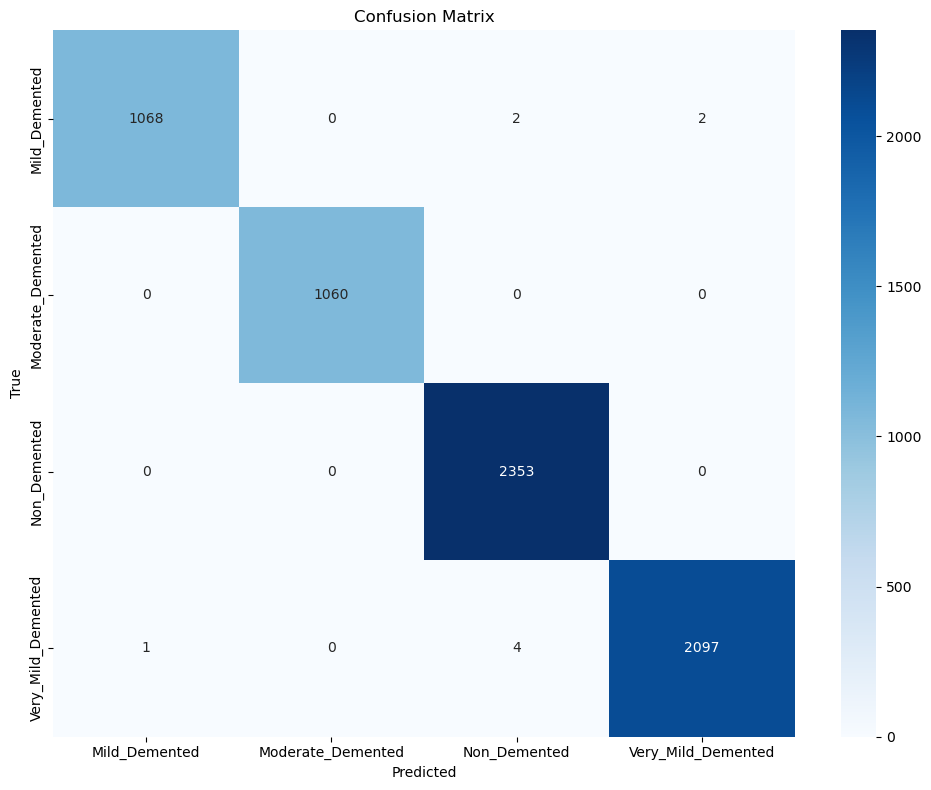


=== CLASS-SPECIFIC PREDICTION VISUALIZATION ===
Class-specific prediction visualization saved to Processed_MRI_Dataset/results/prediction_one_per_class.png


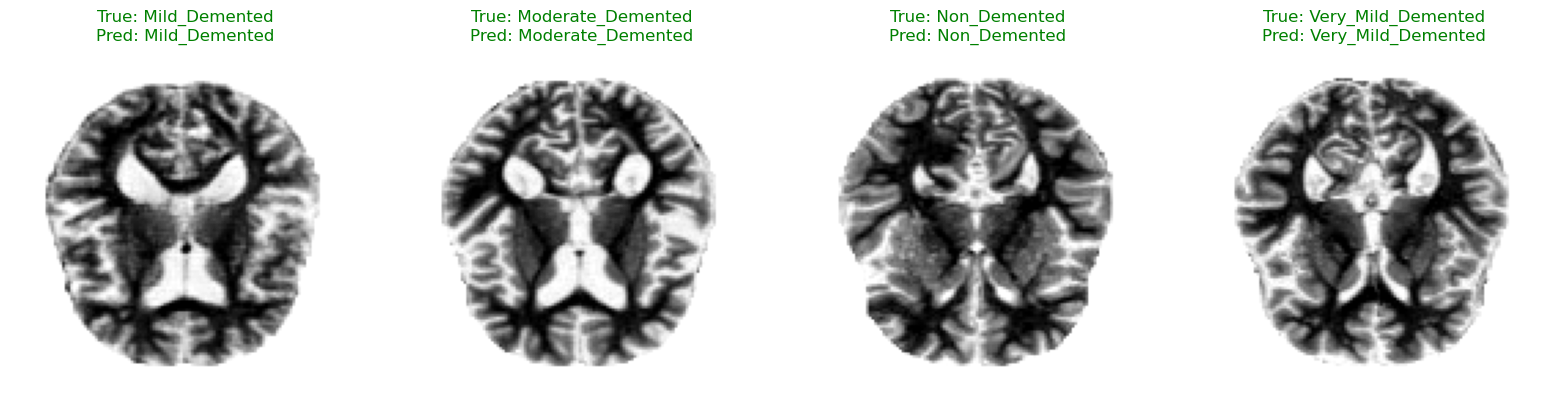


=== CLASS-SPECIFIC ACTIVATION MAPPING ===
Class activation mapping visualization (one per class):
Note: This is a simplified visualization. For detailed GradCAM, consider using pytorch-grad-cam library.


/var/folders/br/8_rtb5dd4ng41b3b4_j0zst80000gn/T/ipykernel_33545/3770093889.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention = torch.tensor(img.squeeze()).numpy()


Class-specific activation map visualization saved to Processed_MRI_Dataset/results/activation_maps_one_per_class.png


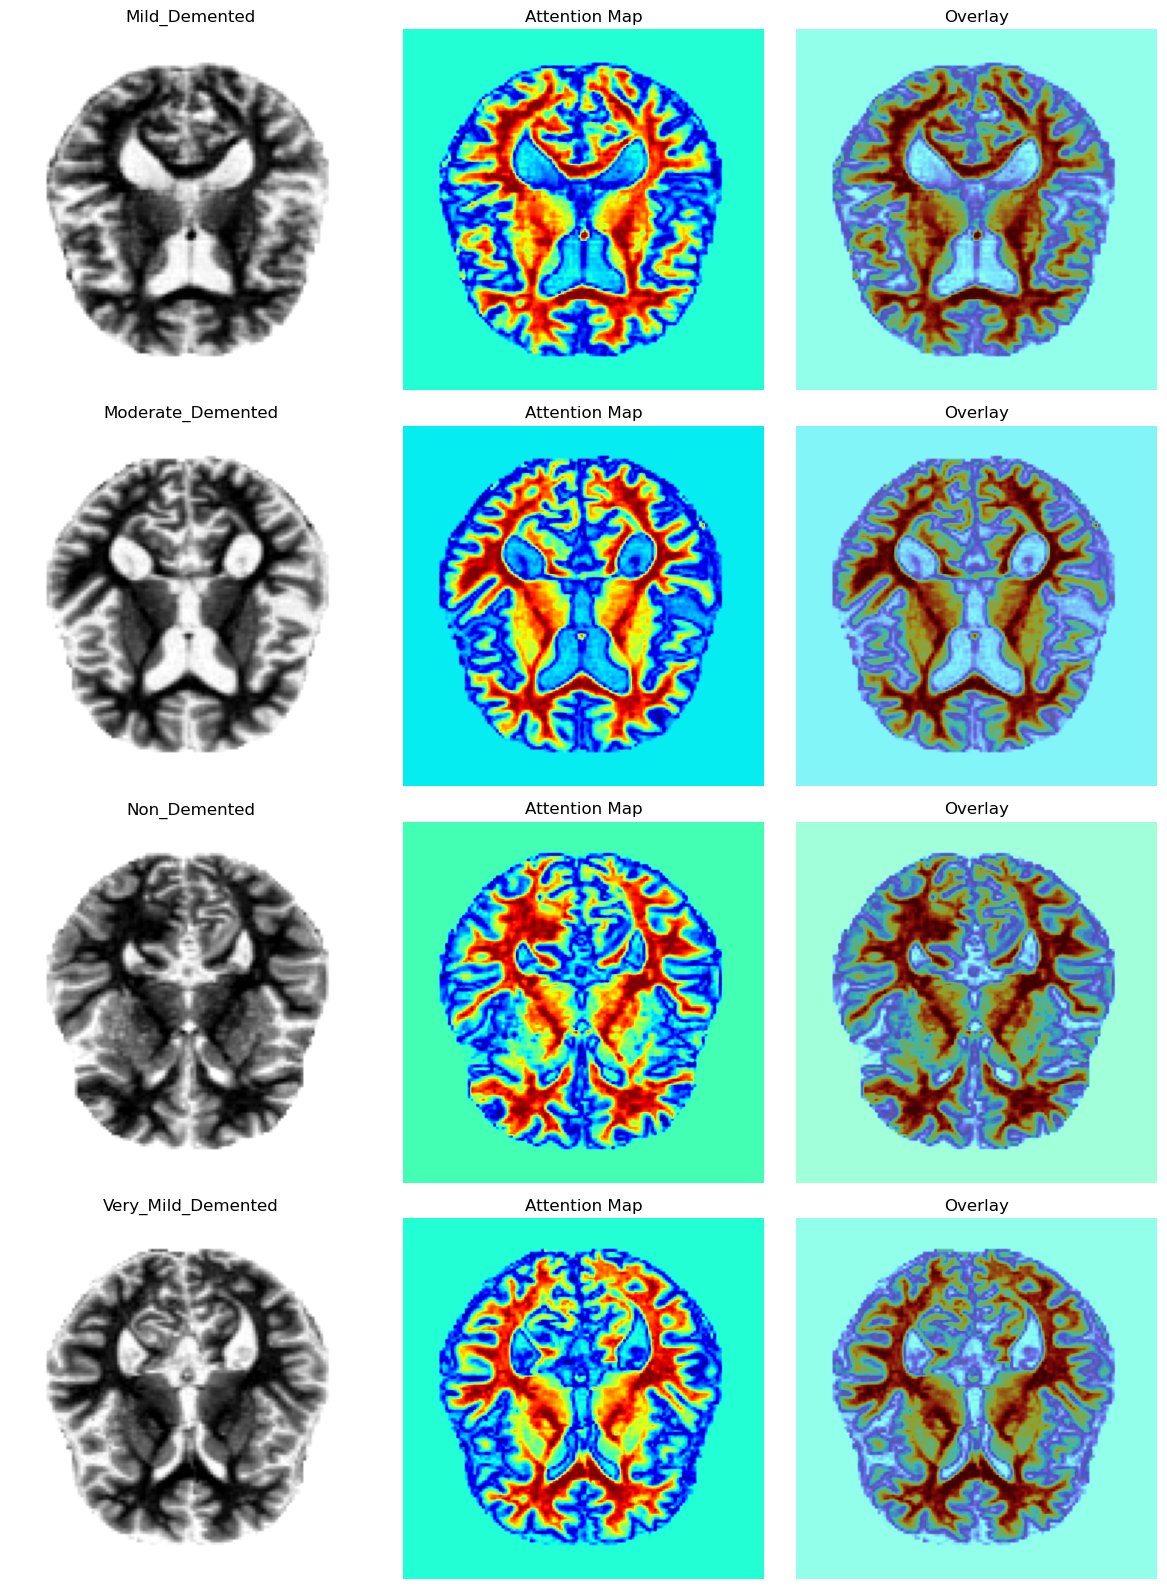


=== ADDITIONAL PREDICTION VISUALIZATIONS ===
Prediction visualization saved to Processed_MRI_Dataset/results/prediction_visualization.png


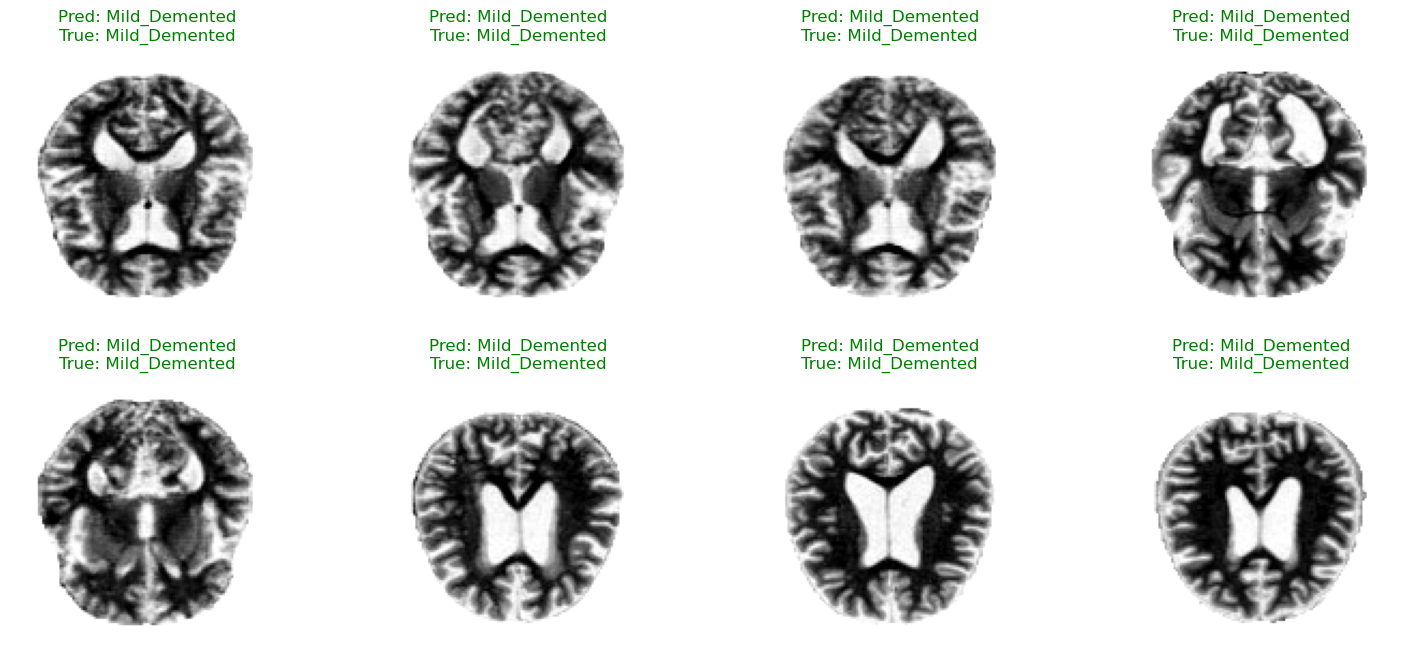


All evaluation results saved to Processed_MRI_Dataset/results


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF

# Constants for Alzheimer's classification
N_CLASSES = 4  # Mild_Demented(0), Moderate_Demented(1), Non_Demented(2), Very_Mild_Demented(3)
CLASS_NAMES = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# Custom Dataset class for test data
class AlzheimerDataset(Dataset):
    def __init__(self, base_dir, split='test'):
        self.base_dir = base_dir
        self.split = split
        
        # Class mapping
        self.classes = {
            'Mild_Demented': 0,
            'Moderate_Demented': 1,
            'Non_Demented': 2,
            'Very_Mild_Demented': 3
        }
        
        # Path to the split directory
        self.data_dir = os.path.join(base_dir, split)
        
        # Collect all images and labels
        self.images = []
        self.labels = []
        
        # Process each class folder
        for class_name, label in self.classes.items():
            class_dir = os.path.join(self.data_dir, class_name)
            
            if os.path.exists(class_dir):
                # Process each image in the class folder
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('ventricle.png')):
                        img_path = os.path.join(class_dir, img_file)
                        self.images.append(img_path)
                        self.labels.append(label)
            else:
                print(f"Warning: Class directory {class_dir} not found.")
        
        print(f"Loaded {len(self.images)} images for {split} split")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.images[idx]
        label = self.labels[idx]
        
        img = Image.open(img_path)
        
        # Convert image to tensor
        img_tensor = TF.to_tensor(img)
        
        return img_tensor, torch.tensor(label, dtype=torch.long)

class AlzheimerCNN(nn.Module):
    def __init__(self, input_channels=1, input_size=(128, 128)):
        super(AlzheimerCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(128)
        
        # Fourth convolutional block for deeper features
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # Calculate feature dimensions after pooling
        # After 4 pooling layers of 2x2, dimensions are reduced by factor of 16
        reduced_h = input_size[0] // 16
        reduced_w = input_size[1] // 16
        self.fc_input_size = 256 * reduced_h * reduced_w
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.out = nn.Linear(128, N_CLASSES)
        
    def forward(self, x):
        # First block
        x = self.batchnorm1(self.pool1(F.relu(self.conv1(x))))
        
        # Second block
        x = self.batchnorm2(self.pool2(F.relu(self.conv2(x))))
        
        # Third block
        x = self.batchnorm3(self.pool3(F.relu(self.conv3(x))))
        
        # Fourth block
        x = self.pool4(F.relu(self.conv4(x)))
        
        # Fully connected layers
        x = self.flatten(x)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.out(x)
        
        return x

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    # Process test data
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Track metrics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store for detailed metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    
    # Print detailed metrics
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    
    return accuracy, cm, report

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, save_path=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")
    
    plt.show()

def visualize_one_per_class(model, test_loader, class_names, save_path=None):
    
    # Visualize model predictions with exactly one sample per class
    
    model.eval()
    samples_by_class = {}  # Dictionary to store one sample per class
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Continue until we have samples for all classes
            if len(samples_by_class) >= len(class_names):
                break
                
            # Get predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Store one sample per class (true class)
            for i in range(images.size(0)):
                label = labels[i].cpu().item()
                # Only add if we don't already have this class
                if label not in samples_by_class:
                    samples_by_class[label] = {
                        'image': images[i].cpu(),
                        'true': label,
                        'pred': preds[i].cpu().item()
                    }
    
    # Create visualization with one sample per class
    fig, axes = plt.subplots(1, len(class_names), figsize=(4*len(class_names), 4))
    
    # Sort by class index to ensure consistent order
    for i, class_idx in enumerate(sorted(samples_by_class.keys())):
        sample = samples_by_class[class_idx]
        img = sample['image']
        true_label = sample['true']
        pred_label = sample['pred']
        
        axes[i].imshow(img.squeeze(), cmap='gray')
        
        # Set title color based on correctness
        title_color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
                          color=title_color)
        axes[i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Class-specific prediction visualization saved to {save_path}")
        
    plt.show()
    
    return samples_by_class  # Return for potential reuse in CAM visualization

def class_activation_mapping_one_per_class(model, test_loader, class_names, samples_by_class=None, save_path=None):
    
    # Generate class activation maps with exactly one sample per class
    
    print("Class activation mapping visualization (one per class):")
    print("Note: This is a simplified visualization. For detailed GradCAM, consider using pytorch-grad-cam library.")
    
    model.eval()
    
    # If samples are not provided, collect them
    if samples_by_class is None:
        samples_by_class = {}
        
        with torch.no_grad():
            for images, labels in test_loader:
                # Continue until we have samples for all classes
                if len(samples_by_class) >= len(class_names):
                    break
                    
                for i in range(images.size(0)):
                    label = labels[i].item()
                    # Only add if we don't already have this class
                    if label not in samples_by_class:
                        samples_by_class[label] = {
                            'image': images[i],
                            'true': label
                        }
    
    # Create activation map visualization
    fig, axes = plt.subplots(len(class_names), 3, figsize=(12, 4*len(class_names)))
    
    # Sort by class index to ensure consistent order
    for i, class_idx in enumerate(sorted(samples_by_class.keys())):
        sample = samples_by_class[class_idx]
        img = sample['image']
        label = sample['true']
        
        # Original image
        axes[i, 0].imshow(img.squeeze(), cmap='gray')
        axes[i, 0].set_title(f"{class_names[label]}")
        axes[i, 0].axis('off')
        
        # For demonstration, create a simulated attention map
        # In a real implementation, this would be from GradCAM or similar
        attention = torch.tensor(img.squeeze()).numpy()
        attention = np.abs(attention - np.mean(attention))
        attention = attention / np.max(attention)
        
        # Show attention map
        axes[i, 1].imshow(attention, cmap='jet')
        axes[i, 1].set_title("Attention Map")
        axes[i, 1].axis('off')
        
        # Overlay on original
        axes[i, 2].imshow(img.squeeze(), cmap='gray')
        axes[i, 2].imshow(attention, cmap='jet', alpha=0.5)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Class-specific activation map visualization saved to {save_path}")
        
    plt.show()

def visualize_predictions(model, test_loader, class_names, num_samples=8, save_path=None):
    
    # Visualize model predictions on random test samples
    
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_samples//4 + 1, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}',
                            color=("green" if preds[j] == labels[j] else "red"))
                ax.imshow(inputs.cpu().data[j].squeeze(), cmap='gray')
                
                if images_so_far == num_samples:
                    if save_path:
                        plt.savefig(save_path)
                        print(f"Prediction visualization saved to {save_path}")
                    plt.tight_layout()
                    plt.show()
                    return
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Prediction visualization saved to {save_path}")
    plt.show()

def get_test_loader(base_dir):
    batch_size = 32
    
    test_dataset = AlzheimerDataset(
        base_dir=base_dir,
        split='test'
    )
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return test_loader

def main():
    base_dir = "Processed_MRI_Dataset"
    model_path = os.path.join(base_dir, "models", "best_model.pt")
    results_dir = os.path.join(base_dir, "results")
    os.makedirs(results_dir, exist_ok=True)
    
    print("Running on CPU only")
    
    # Load test data
    test_loader = get_test_loader(base_dir)
    
    # Load model
    try:
        # Try loading the full model
        checkpoint = torch.load(model_path, map_location='cpu')
        
        # Create a fresh model instance
        img_size = (128, 128)  # Adjust based on your actual image size
        model = AlzheimerCNN(input_size=img_size)
        
        # Load the state dictionary
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Successfully loaded model from epoch {checkpoint['epoch']} with validation accuracy {checkpoint.get('validation_accuracy', 'N/A')}")
    except Exception as e:
        # Try loading just the state dictionary
        print(f"Could not load full model checkpoint: {e}")
        print("Trying to load state dictionary only...")
        
        try:
            state_dict = torch.load(model_path, map_location='cpu')
            img_size = (128, 128)
            model = AlzheimerCNN(input_size=img_size)
            
            # Handle different state dict formats
            if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
                model.load_state_dict(state_dict['model_state_dict'])
            else:
                model.load_state_dict(state_dict)
                
            print("Successfully loaded model state dictionary")
        except Exception as e:
            print(f"Could not load model state dictionary: {e}")
            return
    
    # Evaluate model performance
    print("\n=== MODEL EVALUATION ===")
    accuracy, cm, report = evaluate_model(model, test_loader, CLASS_NAMES)
    
    # Plot and save confusion matrix
    plot_confusion_matrix(
        cm, 
        CLASS_NAMES, 
        save_path=os.path.join(results_dir, "confusion_matrix.png")
    )
    
    # Save classification report
    with open(os.path.join(results_dir, "classification_report.txt"), 'w') as f:
        f.write(f"Test Accuracy: {accuracy:.4f}\n\n")
        f.write("Confusion Matrix:\n")
        f.write(str(cm))
        f.write("\n\nClassification Report:\n")
        f.write(report)
    
    # Visualize predictions (one per class)
    print("\n=== CLASS-SPECIFIC PREDICTION VISUALIZATION ===")
    samples_by_class = visualize_one_per_class(
        model, 
        test_loader, 
        CLASS_NAMES,
        save_path=os.path.join(results_dir, "prediction_one_per_class.png")
    )
    
    # Generate class activation maps (one per class)
    print("\n=== CLASS-SPECIFIC ACTIVATION MAPPING ===")
    class_activation_mapping_one_per_class(
        model,
        test_loader,
        CLASS_NAMES,
        samples_by_class,  # Reuse the same samples
        save_path=os.path.join(results_dir, "activation_maps_one_per_class.png")
    )
    
    # Additional prediction visualizations
    print("\n=== ADDITIONAL PREDICTION VISUALIZATIONS ===")
    visualize_predictions(
        model, 
        test_loader, 
        CLASS_NAMES,
        num_samples=8,
        save_path=os.path.join(results_dir, "prediction_visualization.png")
    )
    
    print(f"\nAll evaluation results saved to {results_dir}")

if __name__ == "__main__":
    main()

In [12]:
'''
link: https://stackoverflow.com/questions/78645142/attention-weights-on-top-of-image

Attention Map: A visual representation highlighting regions of an image that most influenced the model's classification decision. 
It uses a color gradient (typically blue to red) where warmer colors indicate areas the neural network focused on more intensely when making its prediction.

Overlay: A composite visualization that superimposes the attention map onto the original image with partial transparency. 
It allows viewers to simultaneously see both the original anatomical structures and the areas the model deemed important for its diagnosis.
'''

"\nAttention Map: A visual representation highlighting regions of an image that most influenced the model's classification decision. \nIt uses a color gradient (typically blue to red) where warmer colors indicate areas the neural network focused on more intensely when making its prediction.\n\nOverlay: A composite visualization that superimposes the attention map onto the original image with partial transparency. \nIt allows viewers to simultaneously see both the original anatomical structures and the areas the model deemed important for its diagnosis.\n"